In [2]:
import nilearn as nl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle as pkl
import time
import os
import math
from nilearn import plotting
from nilearn import datasets
import time

### Data Fetch & Parameters Setting

In [3]:
data = pkl.load(open( "../data/shuffled_data_pcp.p", "rb" ))
trn_x = data['trn_x']
trn_y = data['trn_y']
val_x = data['val_x']
val_y = data['val_y']

num_label = trn_y.shape[1]
num_trn = trn_x.shape[0]
num_val = val_x.shape[0]
num_node = 48

print(num_label, num_trn, num_val)

2 696 175


In [4]:
#Computation graph params
num_layer = 5
input_size = num_node*num_node
output_size = num_label
num_hidden_units = 1600
dp_rate = 0.0
wd_rate = 0.0005
l_r = 0.00005
num_epoch = 80
batch_size = 20

In [111]:
#Truncate each sample to save only the bottom left part
'''truncated_vector_size = (int)((1+num_node)*num_node/2)
truncated_data = {}
truncated_data['trn_y'] = data['trn_y']
truncated_data['val_y'] = data['val_y']
truncated_data['trn_x'] = np.zeros((num_trn, truncated_vector_size))
truncated_data['val_x'] = np.zeros((num_val, truncated_vector_size))
for i in range(num_trn):
    truncated_trn_x = np.zeros((1, truncated_vector_size))
    start = 0
    for j in range(num_node):
        start = start + j
        truncated_trn_x[0, start:start+j] = data['trn_x'][i, j*num_node : j*num_node + j]
    truncated_data['trn_x'][i, ] = truncated_trn_x

for i in range(num_val):
    truncated_val_x = np.zeros((1, truncated_vector_size))
    start = 0
    for j in range(num_node):
        start = start + j
        truncated_val_x[0, start:start+j] = data['val_x'][i, j*num_node : j*num_node + j]
    truncated_data['val_x'][i, ] = truncated_val_x
    
pkl.dump(truncated_data, open(os.path.join('.', 'truncated_data.p'), 'wb'))'''

"truncated_vector_size = (int)((1+num_node)*num_node/2)\ntruncated_data = {}\ntruncated_data['trn_y'] = data['trn_y']\ntruncated_data['val_y'] = data['val_y']\ntruncated_data['trn_x'] = np.zeros((num_trn, truncated_vector_size))\ntruncated_data['val_x'] = np.zeros((num_val, truncated_vector_size))\nfor i in range(num_trn):\n    truncated_trn_x = np.zeros((1, truncated_vector_size))\n    start = 0\n    for j in range(num_node):\n        start = start + j\n        truncated_trn_x[0, start:start+j] = data['trn_x'][i, j*num_node : j*num_node + j]\n    truncated_data['trn_x'][i, ] = truncated_trn_x\n\nfor i in range(num_val):\n    truncated_val_x = np.zeros((1, truncated_vector_size))\n    start = 0\n    for j in range(num_node):\n        start = start + j\n        truncated_val_x[0, start:start+j] = data['val_x'][i, j*num_node : j*num_node + j]\n    truncated_data['val_x'][i, ] = truncated_val_x\n    \npkl.dump(truncated_data, open(os.path.join('.', 'truncated_data.p'), 'wb'))"

[1. 0.]
[1. 0.]


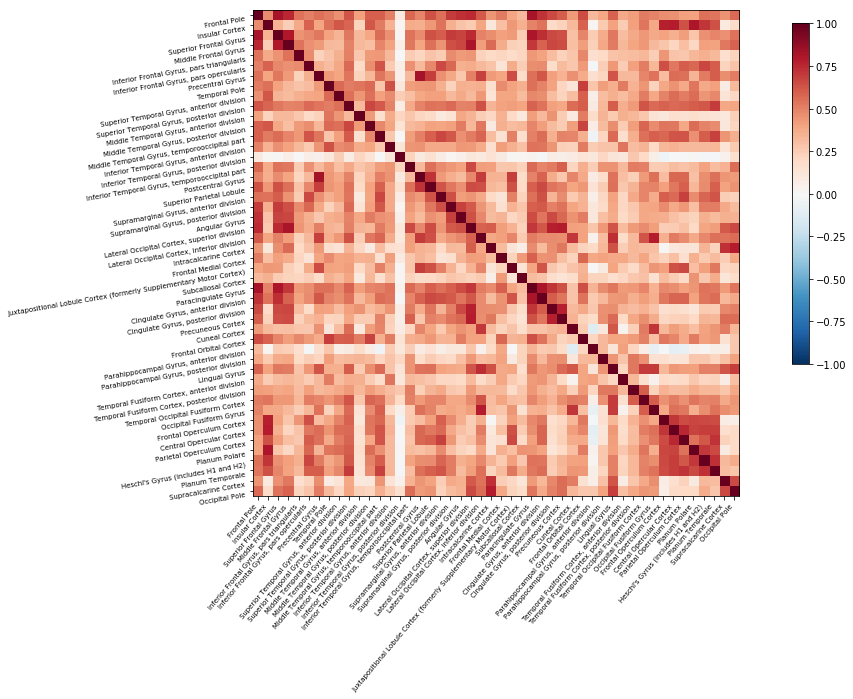

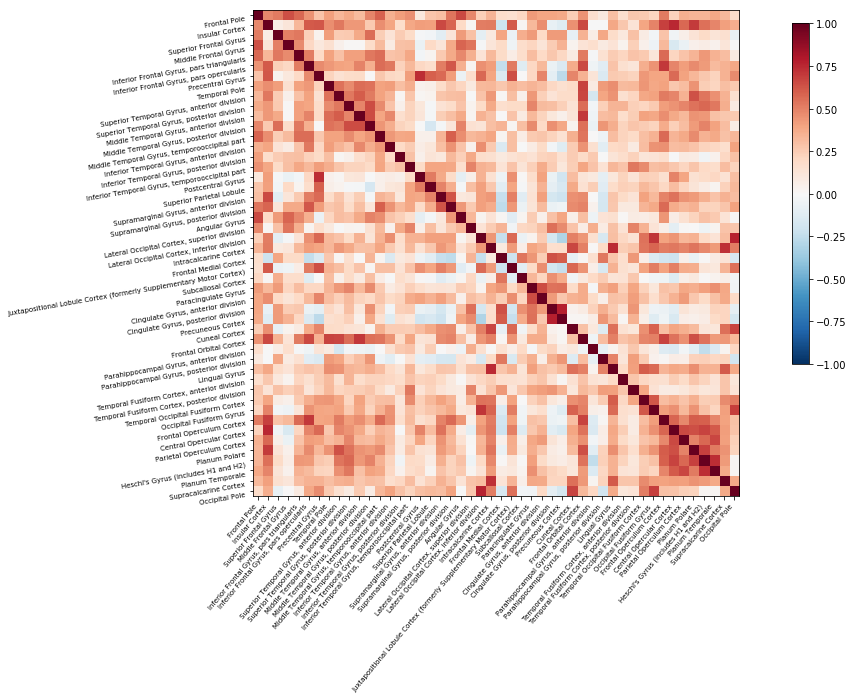

In [9]:
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = dataset.maps
labels = dataset.labels

print(trn_y[19])
print(val_y[19])

display = plotting.plot_matrix(trn_x[19].reshape(48, 48), vmin=-1.0, vmax=1.0, colorbar=True, labels=labels[1:], figure = (10, 10))
plotting.show()

display = plotting.plot_matrix(val_x[19].reshape(48, 48), vmin=-1.0, vmax=1.0, colorbar=True, labels=labels[1:], figure = (10, 10))
plotting.show()

plt.savefig('1.pdf')

### Build Computation Graph

In [113]:
def forward_prop(cur_layer, out_size, dp_rate, is_input):
    
    _, cur_size = [item.value for item in cur_layer.shape]
        
    var = 2.0 / (cur_size + out_size)

    stddev = math.sqrt(var)

    print("steddev is", stddev)
    print(out_size)

    with tf.name_scope('fc'):
        W_fc = tf.Variable(tf.truncated_normal(shape=[cur_size,out_size], stddev=stddev))
        b_fc = tf.Variable(tf.constant(0.0, shape=[out_size]))
        if is_input is False: 
            cur_layer = tf.nn.dropout(cur_layer, 1 - dp_rate)
        out_layer = tf.matmul(cur_layer, W_fc) + b_fc

    return out_layer

def activation(cur_layer, is_output=False):
    if is_output is True:
        return tf.nn.sigmoid(cur_layer)
    return tf.nn.leaky_relu(cur_layer)

def loss_function(yhat, y):
    '''
    '''
    # get the weight decay terms
    with tf.name_scope('wd_term'):
        wght_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='fc')
        wd_term = wd_rate * tf.stack([tf.nn.l2_loss(i) for i in wght_params])

    with tf.name_scope('crit_loss'):
        crit = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=yhat)) + tf.reduce_sum(wd_term)

    return crit

def generate_dataset(x, y, shuffle=True):
    print(batch_size)
    with tf.name_scope('dataset'):
        dataset = tf.data.Dataset.from_tensor_slices((x, y))
        if shuffle: 
            dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
        else:
            dataset = dataset.batch(batch_size)

    return dataset.make_initializable_iterator()

In [114]:
#Build the actual graph
tf.reset_default_graph()
x_place = tf.placeholder('float', [None, input_size], name='input_x')
y_place = tf.placeholder('float', [None,  output_size], name='target_y')
dp_place = tf.placeholder(tf.float32, name='dropout_value')
lr_place = tf.placeholder(tf.float32, name='learning_rate')

cur_layer = x_place

for i in range(num_layer):
    print(i)
    if i != (num_layer - 1):
        print(cur_layer.shape)
        cur_layer = forward_prop(cur_layer, num_hidden_units, dp_place, i == 0)
        cur_layer = activation(cur_layer)
    else:
        cur_layer = forward_prop(cur_layer, output_size, dp_place, i == 0)
        yhat_op = activation(cur_layer, True)

#Cross entropy loss
loss_op = loss_function(yhat_op, y_place)
tf.summary.scalar('Cross_Entropy_Loss', loss_op)

#adam
optimizer = tf.train.AdamOptimizer(lr_place)
train_op = optimizer.minimize(loss_op)

#Accuracy
correct_pred = tf.equal(tf.argmax(y_place, 1), tf.argmax(yhat_op, 1))  
acc_op = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
tf.summary.scalar('Accuracy', acc_op)

#Iterators
trn_it = generate_dataset(trn_x, trn_y, shuffle=True)
val_it = generate_dataset(val_x, val_y, shuffle=False)

0
(?, 2304)
steddev is 0.022633936510629633
1600
1
(?, 1600)
steddev is 0.025
1600
2
(?, 1600)
steddev is 0.025
1600
3
(?, 1600)
steddev is 0.025
1600
4
steddev is 0.03533326266687867
2
20
20


In [115]:
#Actual train loop
if 'session' in locals() and session is not None:
    print('Close interactive session', flush=True)
    session.close()


sess = tf.Session()

# get the summary ready
merged = tf.summary.merge_all()
trn_writer = tf.summary.FileWriter("./log", sess.graph)

saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

# tracing the loss along the way
meta_info = {}
meta_info['trn_loss'] = []
meta_info['trn_acc'] = []
meta_info['val_loss'] = []
meta_info['val_acc'] = []
meta_info['tst_loss'] = []
meta_info['tst_acc'] = []
iteration = 0

start = time.time()

for ep in range(num_epoch):
    sess.run(trn_it.initializer)
    sess.run(val_it.initializer)

    trn_next_batch = trn_it.get_next()

    avg_trn_loss = 0
    avg_trn_acc = 0
    
    n_lr = l_r
    print('TRN:', flush=True)
    while True: # loop to iterate over training set
        try: 
            x, y = sess.run(trn_next_batch)
        except: 
            break
        print('+', end='', flush=True)
        iteration += 1
        
        this_batch_size = x.shape[0]


        _, loss_i, acc_i, summary_i, _yhat, _pred = sess.run([train_op, loss_op, acc_op, merged, yhat_op, correct_pred], 
                                                   feed_dict={x_place:x, y_place:y, dp_place:dp_rate, lr_place:n_lr})

        trn_writer.add_summary(summary_i, iteration)
        avg_trn_loss = avg_trn_loss + loss_i*this_batch_size
        avg_trn_acc = avg_trn_acc + acc_i*this_batch_size
        
        '''print(_yhat, flush=True)
        print(y, flush=True)
        print(_pred, flush=True)
        print(acc_i, flush=True)'''
    
    avg_trn_loss = avg_trn_loss/num_trn
    avg_trn_acc = avg_trn_acc/num_trn
    
    #Validation
    avg_val_loss = 0
    avg_val_acc = 0
    print('VAL:', flush=True)
    # evaluate the loss and accuracy
    pred_and_gt = {}
    pred_and_gt['x'] = []
    pred_and_gt['y'] = []
    pred_and_gt['yhat'] = []
    
    val_next_batch = val_it.get_next()

    while True:
        try: x, y = sess.run(val_next_batch)
        except: break
        print('+', end='', flush=True)
        
        this_batch_size = x.shape[0]
        # compute the loss
        _yhat, _loss, _acc = sess.run([yhat_op, loss_op, acc_op], 
                                   feed_dict={x_place:x, y_place:y, dp_place:0.0})

        # keep track of the loss/pred_and_gt
        pred_and_gt['x'].append(x)
        pred_and_gt['y'].append(y)
        pred_and_gt['yhat'].append(_yhat)
        avg_val_loss = avg_val_loss + _loss*this_batch_size
        avg_val_acc = avg_val_acc + _acc*this_batch_size
    
    avg_val_loss = avg_val_loss/num_val
    avg_val_acc = avg_val_acc/num_val

    print('', flush=True)

    # concatenate the list to numpy array
    for k, v in pred_and_gt.items():
        pred_and_gt[k] = np.concatenate(v)
    
    
    print('\nEp.%05d - TRN: loss %.2f VAL: loss %.2f' % (ep, avg_trn_loss, avg_val_loss), flush=True)
    print('\nEp.%05d - TRN: acc %.2f VAL: acc %.2f' % (ep, avg_trn_acc, avg_val_acc), flush=True)
        
        
    # save learning meta information
    meta_info['trn_loss'].append(avg_trn_loss)
    meta_info['trn_acc'].append(avg_trn_acc)
    meta_info['val_loss'].append(avg_val_loss)
    meta_info['val_acc'].append(avg_val_acc)
    
print("Done")
end = time.time()
print('Time elapsed: %.2f seconds' % (end - start)) 
pkl.dump(meta_info, open(os.path.join('.', 'result.p'), 'wb'))
saver.save(sess, "./model/model")
sess.close()

TRN:
+++++++++++++++++++++++++++++++++++VAL:
+++++++++

Ep.00000 - TRN: loss 1.94 VAL: loss 1.88

Ep.00000 - TRN: acc 0.57 VAL: acc 0.68
TRN:
+++++++++++++++++++++++++++++++++++VAL:
+++++++++

Ep.00001 - TRN: loss 1.80 VAL: loss 1.78

Ep.00001 - TRN: acc 0.73 VAL: acc 0.67
TRN:
+++++++++++++++++++++++++++++++++++VAL:
+++++++++

Ep.00002 - TRN: loss 1.70 VAL: loss 1.72

Ep.00002 - TRN: acc 0.78 VAL: acc 0.70
TRN:
+++++++++++++++++++++++++++++++++++VAL:
+++++++++

Ep.00003 - TRN: loss 1.61 VAL: loss 1.59

Ep.00003 - TRN: acc 0.84 VAL: acc 0.81
TRN:
+++++++++++++++++++++++++++++++++++VAL:
+++++++++

Ep.00004 - TRN: loss 1.52 VAL: loss 1.57

Ep.00004 - TRN: acc 0.89 VAL: acc 0.81
TRN:
+++++++++++++++++++++++++++++++++++VAL:
+++++++++

Ep.00005 - TRN: loss 1.46 VAL: loss 1.49

Ep.00005 - TRN: acc 0.92 VAL: acc 0.87
TRN:
+++++++++++++++++++++++++++++++++++VAL:
+++++++++

Ep.00006 - TRN: loss 1.43 VAL: loss 1.46

Ep.00006 - TRN: acc 0.91 VAL: acc 0.85
TRN:
+++++++++++++++++++++++++++++++++++V

TRN:
+++++++++++++++++++++++++++++++++++VAL:
+++++++++

Ep.00060 - TRN: loss 0.75 VAL: loss 0.77

Ep.00060 - TRN: acc 0.99 VAL: acc 0.97
TRN:
+++++++++++++++++++++++++++++++++++VAL:
+++++++++

Ep.00061 - TRN: loss 0.74 VAL: loss 0.76

Ep.00061 - TRN: acc 0.99 VAL: acc 0.97
TRN:
+++++++++++++++++++++++++++++++++++VAL:
+++++++++

Ep.00062 - TRN: loss 0.73 VAL: loss 0.76

Ep.00062 - TRN: acc 0.99 VAL: acc 0.97
TRN:
+++++++++++++++++++++++++++++++++++VAL:
+++++++++

Ep.00063 - TRN: loss 0.73 VAL: loss 0.75

Ep.00063 - TRN: acc 0.99 VAL: acc 0.97
TRN:
+++++++++++++++++++++++++++++++++++VAL:
+++++++++

Ep.00064 - TRN: loss 0.72 VAL: loss 0.75

Ep.00064 - TRN: acc 0.99 VAL: acc 0.97
TRN:
+++++++++++++++++++++++++++++++++++VAL:
+++++++++

Ep.00065 - TRN: loss 0.72 VAL: loss 0.74

Ep.00065 - TRN: acc 0.99 VAL: acc 0.97
TRN:
+++++++++++++++++++++++++++++++++++VAL:
+++++++++

Ep.00066 - TRN: loss 0.71 VAL: loss 0.73

Ep.00066 - TRN: acc 0.99 VAL: acc 0.97
TRN:
+++++++++++++++++++++++++++++++++++V

In [19]:
tf.reset_default_graph()

imported_graph = tf.train.import_meta_graph('./model/model.meta')

for tensor in tf.get_default_graph().get_operations():
    print (tensor.name)

test_x = np.zeros((1, 2304))
test_x[0, :] = val_x[45]

with tf.Session() as sess:
    imported_graph.restore(sess, './model/model')
    yhat = sess.run(['Sigmoid:0'], feed_dict={'input_x:0':test_x, 'dropout_value:0':0.0})
    print(yhat)

print(val_y[45])

input_x
target_y
dropout_value
learning_rate
fc/truncated_normal/shape
fc/truncated_normal/mean
fc/truncated_normal/stddev
fc/truncated_normal/TruncatedNormal
fc/truncated_normal/mul
fc/truncated_normal
fc/Variable
fc/Variable/Assign
fc/Variable/read
fc/Const
fc/Variable_1
fc/Variable_1/Assign
fc/Variable_1/read
fc/MatMul
fc/add
LeakyRelu/alpha
LeakyRelu/mul
LeakyRelu/Maximum
fc_1/truncated_normal/shape
fc_1/truncated_normal/mean
fc_1/truncated_normal/stddev
fc_1/truncated_normal/TruncatedNormal
fc_1/truncated_normal/mul
fc_1/truncated_normal
fc_1/Variable
fc_1/Variable/Assign
fc_1/Variable/read
fc_1/Const
fc_1/Variable_1
fc_1/Variable_1/Assign
fc_1/Variable_1/read
fc_1/sub/x
fc_1/sub
fc_1/dropout/Shape
fc_1/dropout/random_uniform/min
fc_1/dropout/random_uniform/max
fc_1/dropout/random_uniform/RandomUniform
fc_1/dropout/random_uniform/sub
fc_1/dropout/random_uniform/mul
fc_1/dropout/random_uniform
fc_1/dropout/add
fc_1/dropout/Floor
fc_1/dropout/div
fc_1/dropout/mul
fc_1/MatMul
fc_1/ad

[array([[5.1062748e-02, 9.9990261e-01, 6.6710039e-05]], dtype=float32)]
[1. 0. 0.]
